# Import packages

In [1]:
import pandas as pd
import numpy as np
import re
import sys
sys.path.append(r'./script/')
import datetime
import cobra
from ECMpy_function import *
from ETGEMs_function import *
from concurrent.futures import ProcessPoolExecutor, as_completed
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pyomo.environ as pyo


# Get Concretemodel Need Data

In [2]:
model_file='./data/iCW773_retgems.json'
tem_model = cobra.io.load_json_model(model_file)
metabolite = tem_model.metabolites.get_by_id("lys__L_c")
tem_model.add_boundary(metabolite, "demand")
model_out_file='./analysis/iCW773_lys.json'
cobra.io.save_json_model(tem_model,model_out_file)
reaction_g0_file = "./analysis/g0_compare/reaction_g0_combine.csv"
metabolites_lnC_file = "./data/metabolites_lnC_cg1.txt"
reaction_kcat_MW_combine = "./analysis/kcat_compare/combine_kcat_mw_correct.csv"
starttime = datetime.datetime.now()
obj_id='DM_lys__L_c'#CG_biomass_cgl_ATCC13032
obj_target='maximize'
E_total=0.129 #eaual to e_pool （0.228）* saturation（0.5）0.227
substrate_name='EX_glc_e_reverse'
K_value=2765
B_value=0

exp_comp_genes_file='./data/transcriptome/cg_exp_comp_genes_lysine.csv' 
exp_comp_genes = pd.read_csv(exp_comp_genes_file,index_col=0)
exp_comp={}
exp_comp['genes']=exp_comp_genes.index
exp_comp['expression']=exp_comp_genes
reg_net_file='./analysis/regulation/trn_combine_final.csv'
reg_net = pd.read_csv(reg_net_file)
reg_net = reg_net.drop(columns=reg_net.columns[-1])


# Calculate MDF for pathway

0:00:09.197473


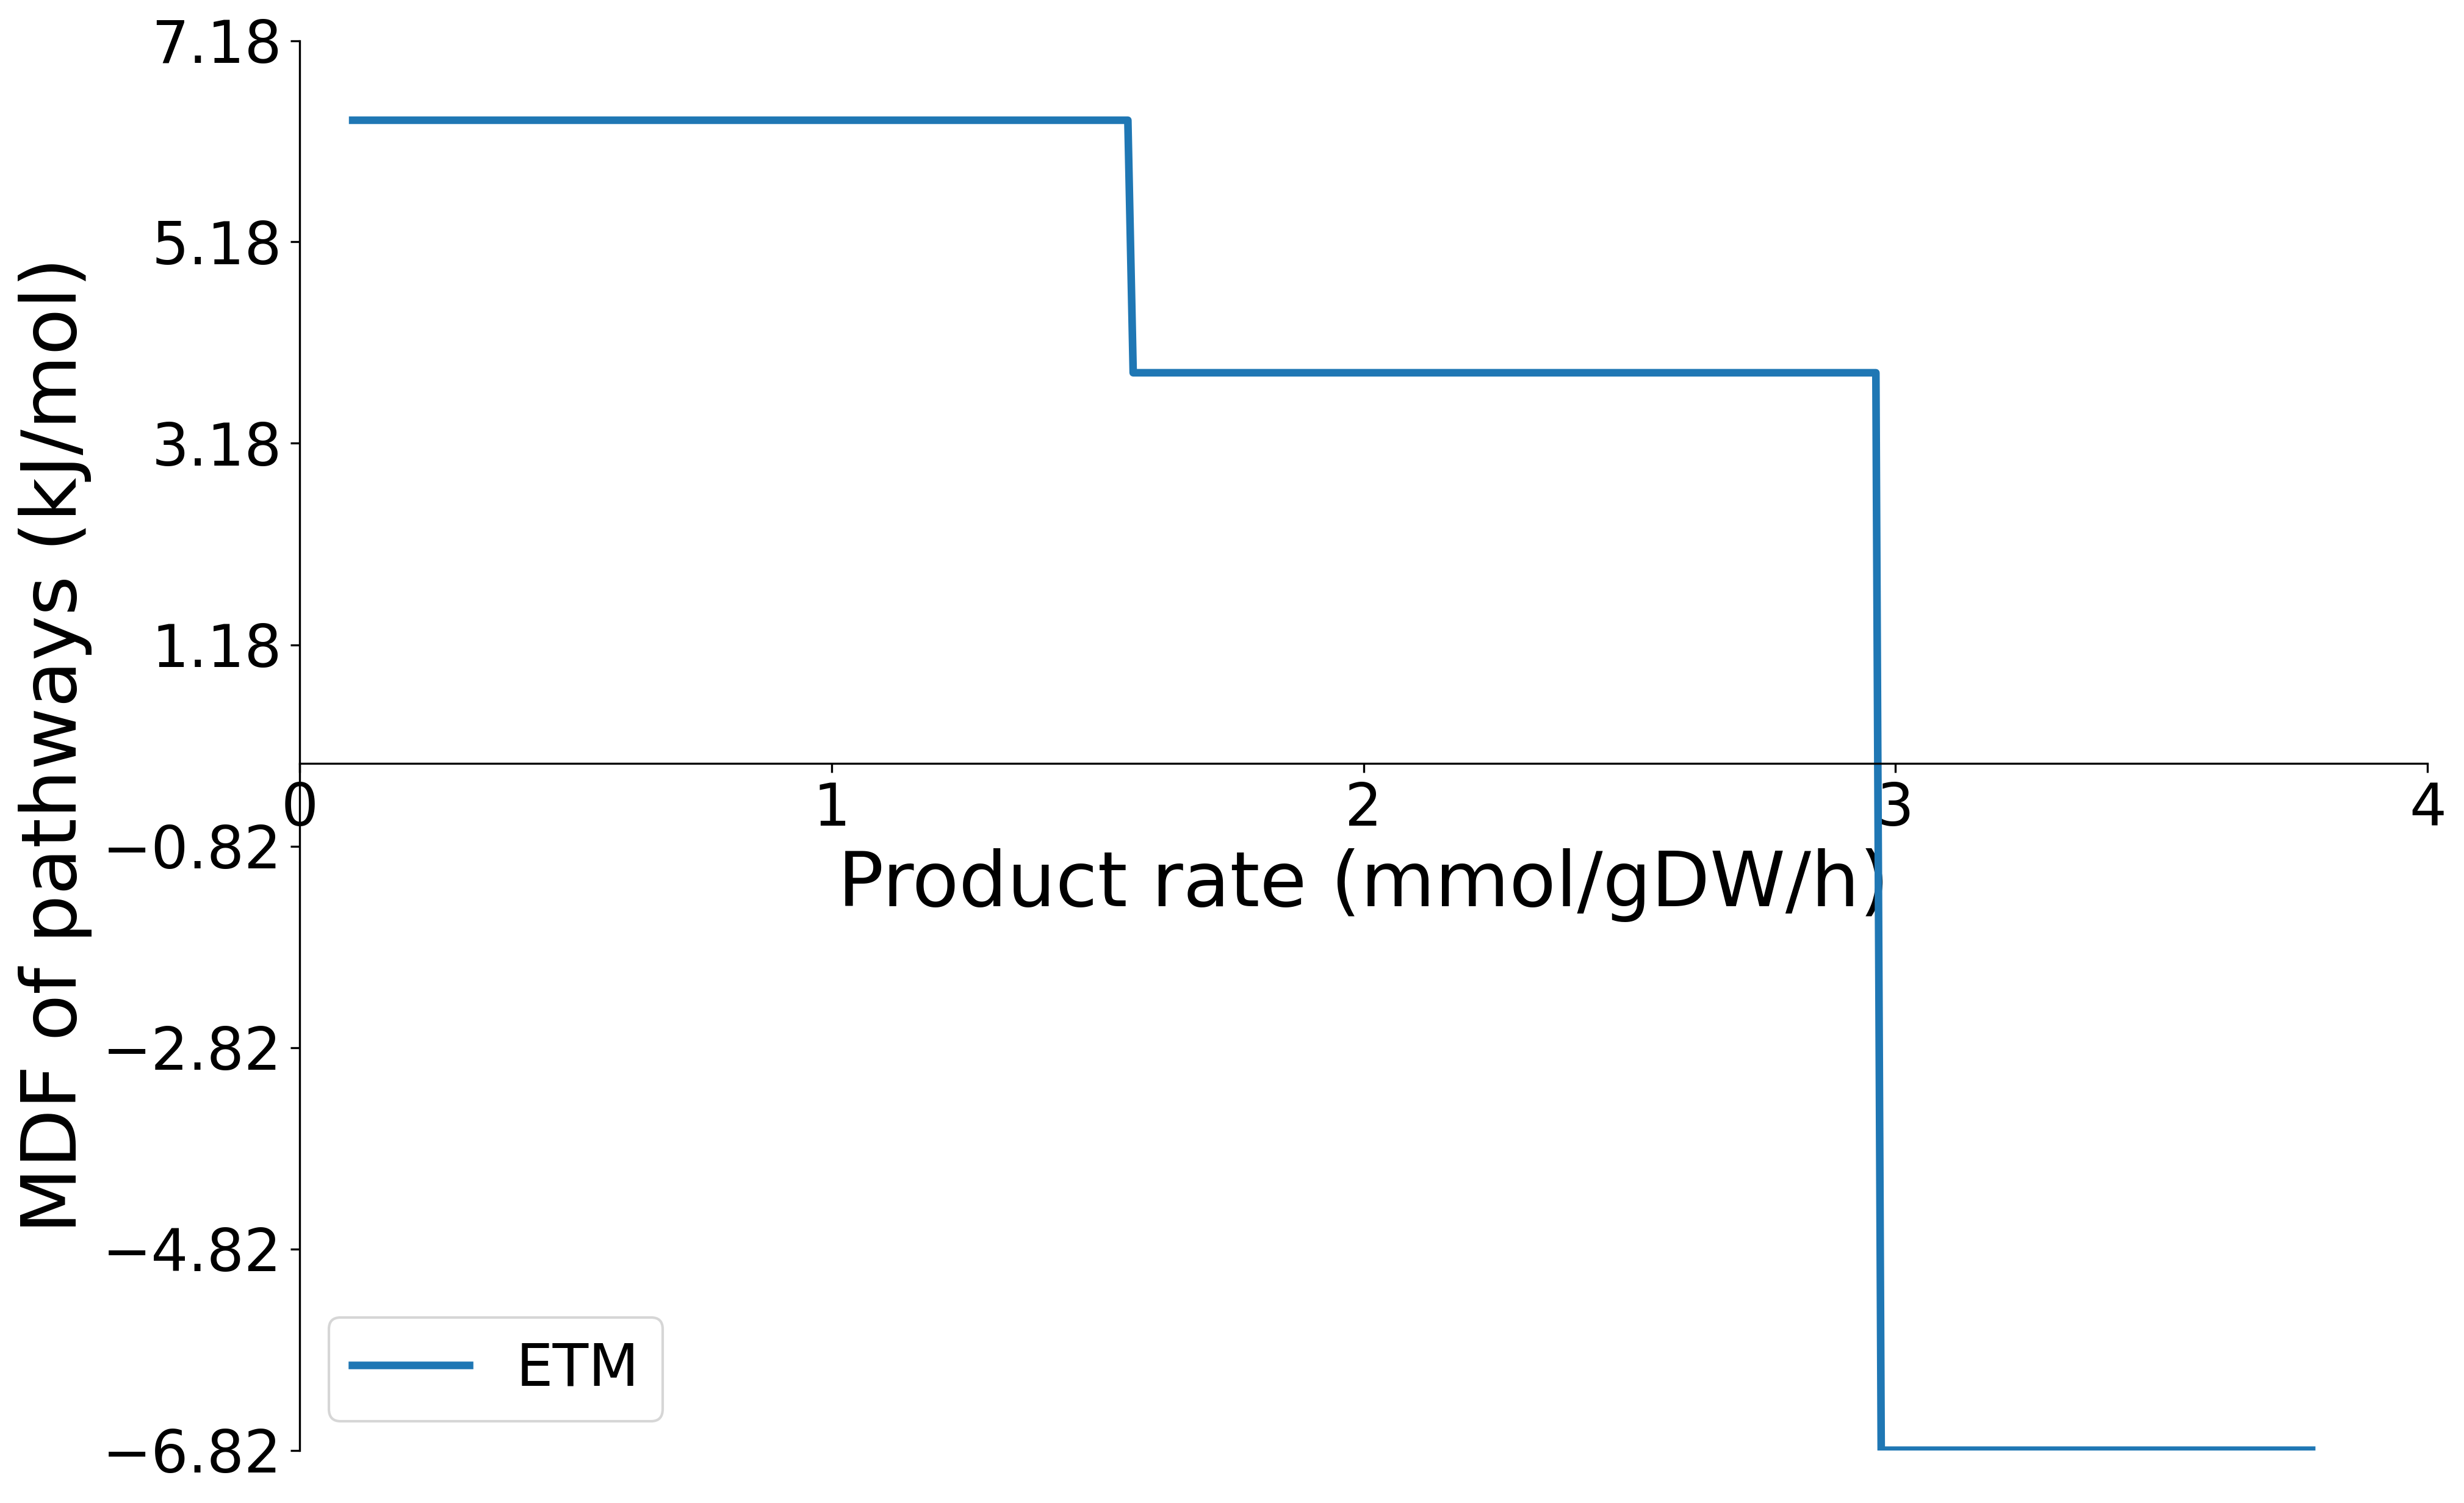

In [3]:
import matplotlib.pyplot as plt

Concretemodel_Need_Data_combine = Get_Concretemodel_Need_Data(reaction_g0_file,metabolites_lnC_file,model_out_file,reaction_kcat_MW_combine)
substrate_value = 4.67
etm = EcoETM(Concretemodel_Need_Data_combine,obj_id,obj_target,substrate_name,substrate_value,E_total,K_value,B_value)
opt_etm = Model_Solve(etm, "cplex_direct")

[MDF_list, MDF_df] = calculate_MDF_list(Concretemodel_Need_Data_combine, obj_id, substrate_name, substrate_value, K_value, E_total, "./analysis/MDF_lysine.csv")

#plt.rcParams['font.family'] = 'Times New Roman'
MDF_dict = {"ETM" : MDF_list}
# MDF_list = pd.read_csv(MDF_result_file, index_col=0)
#ytick = [ -2,0,2,4,6,8,10,12,14]
if MDF_df['MDF'].min()<0:
    ytick = list(np.arange(MDF_df['MDF'].min(), MDF_df['MDF'].max() + 2, 2))
else:
    ytick = list(np.arange(0, MDF_df['MDF'].max() + 2, 2))
    
png_file = "./analysis/figure/max_MDF_lys.png"
xlab = "Product rate (mmol/gDW/h)"
Draw_MDF_By_Product_rate(MDF_dict,0,xlab, 4.0,1,ytick,png_file)

# Based on the B value, calculate the bottleneck reactions, limiting metabolites, key enzymes， and key TF in the pathway.

## Inflection 1

In [4]:
Concretemodel_Need_Data_combine = Get_Concretemodel_Need_Data(reaction_g0_file,metabolites_lnC_file,model_out_file,reaction_kcat_MW_combine)

etm1 = EcoETM(Concretemodel_Need_Data_combine,obj_id,obj_target,substrate_name,substrate_value,E_total,K_value,6.0)
opt_etm1 = Model_Solve(etm1, "cplex_direct")

B_value1=MDF_Calculation(Concretemodel_Need_Data_combine,opt_etm1.obj(),obj_id,substrate_name,substrate_value,K_value,E_total,'cplex_direct')
print("obj value : " +str(opt_etm1.obj()))
print("B value1 : " +str(B_value1))

obj value : 1.5566666666677655
B value1 : 6.387361645465539


### Bottleneck reaction mining

In [5]:
obj_value = opt_etm1.obj()
B_value = B_value1

[min_V,Concretemodel]=Min_Flux_Sum_Calculation(Concretemodel_Need_Data_combine,obj_value,obj_id,substrate_name,substrate_value,K_value,E_total,B_value,'cplex_direct')
print("Min flux amount : " +str(min_V))

max_min_Df_list_fixed_file = './analysis/max_min_Df_complete_for_specific_reaction_cg_%s_%s_%s.csv'%(obj_id,obj_value,B_value)
Bottleneck_reaction_met_file = './analysis/Bottleneck_reaction_met_%s_%s_%s.csv'%(obj_id,obj_value,B_value)

max_min_concentration_list_fixed_file = './analysis/max_min_concentration_for_specific_metabolite_cg_%s_%s_%s.csv'%(obj_id,obj_value,B_value)
Limiting_metabolite_file = './analysis/Limiting_metabolite_%s_%s_%s.csv'%(obj_id,obj_value,B_value)

max_min_E_list_fixed_file = './analysis/max_min_E_cg_%s_%s_%s.csv'%(obj_id,obj_value,B_value)
Limiting_enzyme_file = './analysis/Limiting_enzyme_%s_%s_%s.csv'%(obj_id,obj_value,B_value)

model=Concretemodel_Need_Data_combine['model']
reaction_kcat_MW=Concretemodel_Need_Data_combine['reaction_kcat_MW']
reaction_g0=Concretemodel_Need_Data_combine['reaction_g0']
coef_matrix=Concretemodel_Need_Data_combine['coef_matrix']
metabolite_list=Concretemodel_Need_Data_combine['metabolite_list']
use_result = Get_Results_Thermodynamics(model,Concretemodel,reaction_kcat_MW,reaction_g0,coef_matrix,metabolite_list)
use_result = use_result[use_result['flux'] > 1e-10] 
use_result = use_result.sort_values(by = 'flux',axis = 0,ascending = False)
use_result["reaction"] = use_result.apply(lambda row: model.reactions.get_by_id(row.name).reaction, axis = 1)
use_result["gpr"] = use_result.apply(lambda row: model.reactions.get_by_id(row.name).gene_reaction_rule, axis = 1)
use_result.to_csv('./analysis/' + str(round(obj_value,3)) + '_' + str(round(B_value,3)) + '_CGETM.csv', sep=',', header=True, index=True,mode='w')

use_result_tmp=use_result[use_result['f']>-K_value]
use_result_select=use_result_tmp[abs(use_result_tmp['f']-B_value)<=1e-05]
use_result_select.head(10)

Min flux amount : 282.5350000005359


,flux,z,f,enz,met_concentration,reaction,gpr
GND,9.340000,1.0,6.387362,0.003613,;6pgc_c : 0.0012347432651269035;co2_c : 9.1963...,6pgc_c + nadp_c --> co2_c + nadph_c + ru5p__D_c,Cgl1452
PGL,9.340000,1.0,6.387362,0.017764,;6pgc_c : 0.0012347432651269035;6pgl_c : 5.474...,6pgl_c + h2o_c --> 6pgc_c + h_c,Cgl1578
G6PDH2r,9.340000,1.0,6.387362,0.000120,;6pgl_c : 5.47468036808955e-07;g6p_c : 3.42101...,g6p_c + nadp_c --> 6pgl_c + h_c + nadph_c,Cgl1576
RPE,6.226667,1.0,6.387362,0.000031,;ru5p__D_c : 0.02000000000856292;xu5p__D_c : 0...,ru5p__D_c --> xu5p__D_c,Cgl1598
PGI_reverse,4.670000,1.0,6.387362,0.000062,;f6p_c : 1.5444459501407125e-05;g6p_c : 3.4210...,f6p_c --> g6p_c,Cgl0851
PGK,4.670000,1.0,6.387362,0.000519,;13dpg_c : 5.141725082914021e-06;3pg_c : 8.302...,13dpg_c + adp_c --> 3pg_c + atp_c,Cgl1587
ENO,4.670000,1.0,6.387362,0.000880,;2pg_c : 1.3167910781202866e-06;h2o_c : 1.0;pe...,2pg_c --> h2o_c + pep_c,Cgl0974
PGM_num1,4.670000,1.0,6.387362,0.000102,;2pg_c : 1.3167910781202866e-06;3pg_c : 8.3029...,3pg_c --> 2pg_c,Cgl1058
GAPD_num1,4.670000,1.0,6.387362,0.007891,;13dpg_c : 5.141725082914021e-06;g3p_c : 0.020...,g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c,Cgl0937
TKT2,3.113333,1.0,6.387362,0.000214,;e4p_c : 9.98343730241903e-06;f6p_c : 1.544445...,e4p_c + xu5p__D_c --> f6p_c + g3p_c,Cgl1575


In [6]:
starttime = datetime.datetime.now()
max_min_Df_list_fixed=pd.DataFrame()
path_reac_list=list(use_result_select.index)

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Df_Complete,Concretemodel_Need_Data_combine,eachreaction,'maximize',K_value,B_value,obj_value,\
                               obj_id,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in path_reac_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_Df_list_fixed.loc[eachindex,'max_Df_complete']=tmp.loc[eachindex,'max_value']

max_min_Df_list_fixed=max_min_Df_list_fixed.sort_values(by='max_Df_complete',ascending = True)
max_min_Df_list_fixed.to_csv(max_min_Df_list_fixed_file, sep=',', header=True, index=True,mode='w')

endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_Df_list_fixed.head(10)

0:02:25.036497


,max_Df_complete
PGM_num1,6.387368
GAPD_num1,6.387368
ASAD_reverse,6.387368
ENO,6.387368
ASPK,6.387368
PGK,6.387368
ACONTb,13.141359
ACONTa,13.141359
PGI_reverse,18.190910
RPE,18.190910


In [7]:
Bottleneck_reaction=max_min_Df_list_fixed[(max_min_Df_list_fixed['max_Df_complete']-B_value)<=0.001]
Bottleneck_reaction

,max_Df_complete
PGM_num1,6.387368
GAPD_num1,6.387368
ASAD_reverse,6.387368
ENO,6.387368
ASPK,6.387368
PGK,6.387368


### Exploration of limited metabolites

In [8]:
Bottleneck_reaction_list=list(Bottleneck_reaction.index)
Bottleneck_reaction_met=[]
for rea in model.reactions:
    if rea.id in Bottleneck_reaction_list:
        #print(rea)
        for met in model.metabolites:
            try:
                rea.get_coefficient(met.id)  
            except:
                pass
            else:
                if met.id !='h_c' and met.id !='h2o_c':
                    Bottleneck_reaction_met.append(met.id)
                
Bottleneck_reaction_met=list(set(Bottleneck_reaction_met))
Bottleneck_reaction_met_df = pd.DataFrame(Bottleneck_reaction_met, columns=['Bottleneck_reactions'])
Bottleneck_reaction_met_df.to_csv(Bottleneck_reaction_met_file, sep=',', header=True, index=True,mode='w')
Bottleneck_reaction_met_df

,Bottleneck_reactions
0,2pg_c
1,13dpg_c
2,atp_c
3,adp_c
4,pep_c
5,pi_c
6,aspsa_c
7,nadp_c
8,asp__L_c
9,g3p_c


In [9]:
starttime = datetime.datetime.now()
max_min_concentration_list_fixed = pd.DataFrame()

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Met_Concentration,Concretemodel_Need_Data_combine,eachmet,'maximize',K_value,B_value,\
        obj_value,obj_id,E_total,substrate_name,substrate_value,list(Bottleneck_reaction.index),'cplex_direct'): eachmet for eachmet in Bottleneck_reaction_met}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_concentration_list_fixed.loc[eachindex,'max_concentration'] = tmp.loc[eachindex,'max_value']

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Met_Concentration,Concretemodel_Need_Data_combine,eachmet,'minimize',K_value,B_value,\
        obj_value,obj_id,E_total,substrate_name,substrate_value,list(Bottleneck_reaction.index),'cplex_direct'): eachmet for eachmet in Bottleneck_reaction_met}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_concentration_list_fixed.loc[eachindex,'min_concentration'] = tmp.loc[eachindex,'min_value']
            
endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_concentration_list_fixed.to_csv(max_min_concentration_list_fixed_file, sep=',', header=True, index=True,mode='w')
max_min_concentration_list_fixed

0:01:38.512660


,max_concentration,min_concentration
13dpg_c,-12.178120,-12.178122
atp_c,-3.912023,-12.206073
aspsa_c,-14.508655,-14.508658
nadh_c,-6.214608,-14.508658
nad_c,-3.912023,-12.206073
nadp_c,-6.214608,-14.508658
nadph_c,-3.912023,-12.206073
pi_c,-8.053225,-8.053228
4pasp_c,-12.539008,-12.539010
3pg_c,-9.396316,-9.396318


In [10]:
Limiting_metabolite = max_min_concentration_list_fixed[(max_min_concentration_list_fixed['max_concentration'] - max_min_concentration_list_fixed['min_concentration']) <= 0.001]
Limiting_metabolite.to_csv(Limiting_metabolite_file, sep=',', header=True, index=True,mode='w')

Limiting_metabolite

,max_concentration,min_concentration
13dpg_c,-12.178120,-12.178122
aspsa_c,-14.508655,-14.508658
pi_c,-8.053225,-8.053228
4pasp_c,-12.539008,-12.539010
3pg_c,-9.396316,-9.396318
pep_c,-14.508655,-14.508658
2pg_c,-13.540310,-13.540313
asp__L_c,-3.912023,-3.912025
g3p_c,-3.912023,-3.912025


### Key enzyme mining

In [11]:
use_result_enz = use_result_tmp.sort_values(by='enz',ascending = False)
use_result_enz.head(10)

,flux,z,f,enz,met_concentration,reaction,gpr
CYTBDpp,23.350000,1.0,110.345800,0.020899,;h2o_c : 1.0;h_c : 1.0;h_e : 1.0;o2_c : 0.0002...,2.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 2.0 h_...,Cgl2194 and Cgl2523 and Cgl2195 and Cgl2192
PGL,9.340000,1.0,6.387362,0.017764,;6pgc_c : 0.0012347432651269035;6pgl_c : 5.474...,6pgl_c + h2o_c --> 6pgc_c + h_c,Cgl1578
PYRC,1.556667,1.0,6.387362,0.009198,;adp_c : 4.999999992621078e-07;atp_c : 4.99999...,atp_c + hco3_c + pyr_c --> adp_c + h_c + oaa_c...,Cgl0689
GAPD_num1,4.670000,1.0,6.387362,0.007891,;13dpg_c : 5.141725082914021e-06;g3p_c : 0.020...,g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c,Cgl0937
GND,9.340000,1.0,6.387362,0.003613,;6pgc_c : 0.0012347432651269035;co2_c : 9.1963...,6pgc_c + nadp_c --> co2_c + nadph_c + ru5p__D_c,Cgl1452
G3PT,1.556667,1.0,44.396250,0.003251,;glyc3p_c : 2.8499404076472728e-05;glyc_c : 4....,glyc3p_c + h2o_c --> glyc_c + pi_c,Cgl1506
MDH2,1.556667,1.0,72.489101,0.002383,;mal__L_c : 0.0026814493314070023;oaa_c : 0.02...,mal__L_c + q8_c --> oaa_c + q8h2_c,Cgl2001
G3PD2_reverse,1.556667,1.0,17.311392,0.002302,;dhap_c : 4.999999992621078e-07;glyc3p_c : 2.8...,dhap_c + h_c + nadph_c --> glyc3p_c + nadp_c,Cgl1320
FBA,1.556667,1.0,13.687108,0.002133,;dhap_c : 4.999999992621078e-07;fdp_c : 0.0197...,fdp_c --> dhap_c + g3p_c,Cgl2770
ICDHyr,1.556667,1.0,18.569539,0.002087,;akg_c : 4.999999992621078e-07;co2_c : 9.19632...,icit_c + nadp_c --> akg_c + co2_c + nadph_c,Cgl0664


In [12]:
enz_use_reaction_list = list(use_result_enz[use_result_enz['enz'] > 0.00129].index)

In [13]:
starttime = datetime.datetime.now()
max_min_E_list_fixed = pd.DataFrame()

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_E,Concretemodel_Need_Data_combine,eachreaction,'maximize',K_value,B_value,\
                    obj_value,obj_id,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in enz_use_reaction_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_E_list_fixed.loc[eachindex,'max_E']=tmp.loc[eachindex,'max_value']

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_E,Concretemodel_Need_Data_combine,eachreaction,'minimize',K_value,B_value,\
                    obj_value,obj_id,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in enz_use_reaction_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_E_list_fixed.loc[eachindex,'min_E']=tmp.loc[eachindex,'min_value']

max_min_E_list_fixed.sort_values(by='max_E',ascending = False)        
endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_E_list_fixed.to_csv(max_min_E_list_fixed_file, sep=',', header=True, index=True,mode='w')
max_min_E_list_fixed

0:02:09.706555


,max_E,min_E
GAPD_num1,0.007891,0.000000
ICDHyr,0.002087,0.002087
GND,0.005420,0.003613
PGL,0.026646,0.017764
MDH2,0.038146,0.000000
PYRC,0.018397,0.008699
AKGDH,0.001959,0.001959
PDH,0.002027,0.000000
CYTBDpp,0.030653,0.000000
G3PD2_reverse,0.033402,0.000000


In [14]:
Limiting_enzyme = max_min_E_list_fixed[(max_min_E_list_fixed['max_E'] - max_min_E_list_fixed['min_E']) <= 0.001]
Limiting_enzyme.to_csv(Limiting_enzyme_file, sep=',', header=True, index=True,mode='w')

Limiting_enzyme

,max_E,min_E
ICDHyr,0.002087,0.002087
AKGDH,0.001959,0.001959
DHDPRy,0.001549,0.001549


### Regulatory factor target mining

In [15]:
Concretemodel_Need_Data_combine = Get_Concretemodel_Need_Data(reaction_g0_file,metabolites_lnC_file,model_out_file,reaction_kcat_MW_combine)
biomass_id = 'CG_biomass_cgl_ATCC13032'

tf_result = BeReTa_use(model_out_file, Concretemodel_Need_Data_combine, reg_net, exp_comp, biomass_id, obj_id, substrate_name,substrate_value,E_total,K_value,B_value, 0.05, 1, 0.0)
tf_result.to_csv("./analysis/bereta_result_MDF_%s_%s.csv"%(obj_id,B_value))
tf_result

,beneficial_score,beneficial_score_pval,n_effective_genes,n_effective_rxns,f_effective_genes
Cgl0291,62.442182,0.0000,23.0,31.0,0.160839
Cgl1185,-47.215988,0.0000,1.0,2.0,0.142857
Cgl2527,-15.445405,0.0123,8.0,9.0,0.400000
Cgl1718,-14.309693,0.0134,6.0,7.0,0.428571
Cgl1171,9.097704,0.0001,1.0,2.0,0.111111
Cgl0254,-0.213612,0.0331,1.0,1.0,1.000000


## Inflection 2

In [16]:
Concretemodel_Need_Data_combine = Get_Concretemodel_Need_Data(reaction_g0_file,metabolites_lnC_file,model_out_file,reaction_kcat_MW_combine)

etm2 = EcoETM(Concretemodel_Need_Data_combine,obj_id,obj_target,substrate_name,substrate_value,E_total,K_value,2.0)
opt_etm2 = Model_Solve(etm2, "cplex_direct")

B_value2=MDF_Calculation(Concretemodel_Need_Data_combine,opt_etm2.obj(),obj_id,substrate_name,substrate_value,K_value,E_total,'cplex_direct')
print("obj value : " +str(opt_etm2.obj()))
print("B value2 : " +str(B_value2))

obj value : 2.9629941040070245
B value2 : 3.8792731231430695


### Bottleneck reaction mining

In [17]:
obj_value = opt_etm2.obj()
B_value = B_value2

[min_V,Concretemodel]=Min_Flux_Sum_Calculation(Concretemodel_Need_Data_combine,obj_value,obj_id,substrate_name,substrate_value,K_value,E_total,B_value,'cplex_direct')
print("Min flux amount : " +str(min_V))

max_min_Df_list_fixed_file = './analysis/max_min_Df_complete_for_specific_reaction_cg_%s_%s_%s.csv'%(obj_id,obj_value,B_value)
Bottleneck_reaction_met_file = './analysis/Bottleneck_reaction_met_%s_%s_%s.csv'%(obj_id,obj_value,B_value)

max_min_concentration_list_fixed_file = './analysis/max_min_concentration_for_specific_metabolite_cg_%s_%s_%s.csv'%(obj_id,obj_value,B_value)
Limiting_metabolite_file = './analysis/Limiting_metabolite_%s_%s_%s.csv'%(obj_id,obj_value,B_value)

max_min_E_list_fixed_file = './analysis/max_min_E_cg_%s_%s_%s.csv'%(obj_id,obj_value,B_value)
Limiting_enzyme_file = './analysis/Limiting_enzyme_%s_%s_%s.csv'%(obj_id,obj_value,B_value)

model=Concretemodel_Need_Data_combine['model']
reaction_kcat_MW=Concretemodel_Need_Data_combine['reaction_kcat_MW']
reaction_g0=Concretemodel_Need_Data_combine['reaction_g0']
coef_matrix=Concretemodel_Need_Data_combine['coef_matrix']
metabolite_list=Concretemodel_Need_Data_combine['metabolite_list']
use_result = Get_Results_Thermodynamics(model,Concretemodel,reaction_kcat_MW,reaction_g0,coef_matrix,metabolite_list)
use_result = use_result[use_result['flux'] > 1e-10] 
use_result = use_result.sort_values(by = 'flux',axis = 0,ascending = False)
use_result["reaction"] = use_result.apply(lambda row: model.reactions.get_by_id(row.name).reaction, axis = 1)
use_result["gpr"] = use_result.apply(lambda row: model.reactions.get_by_id(row.name).gene_reaction_rule, axis = 1)
use_result.to_csv('./analysis/' + str(round(obj_value,3)) + '_' + str(round(B_value,3)) + '_CGETM.csv', sep=',', header=True, index=True,mode='w')

use_result_tmp=use_result[use_result['f']>-K_value]
use_result_select=use_result_tmp[abs(use_result_tmp['f']-B_value)<=1e-05]
use_result_select.head(10)

Min flux amount : 279.974491156147


,flux,z,f,enz,met_concentration,reaction,gpr
PYRC,9.145870,1.0,3.879273,0.054043,;adp_c : 4.999999992621078e-07;atp_c : 4.99999...,atp_c + hco3_c + pyr_c --> adp_c + h_c + oaa_c...,Cgl0689
GAPD_num1,8.888982,1.0,3.879273,0.015019,;13dpg_c : 4.999999992621078e-07;g3p_c : 0.000...,g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c,Cgl0937
ENO,8.888982,1.0,3.879273,0.001675,;2pg_c : 8.955390055019545e-07;h2o_c : 1.0;pep...,2pg_c --> h2o_c + pep_c,Cgl0974
PGK,8.888982,1.0,3.879273,0.000988,;13dpg_c : 4.999999992621078e-07;3pg_c : 2.135...,13dpg_c + adp_c --> 3pg_c + atp_c,Cgl1587
PGM_num4,8.888982,1.0,3.879273,-9999.000000,;2pg_c : 8.955390055019545e-07;3pg_c : 2.13523...,3pg_c --> 2pg_c,
ME2,6.182876,1.0,3.879273,0.009454,;co2_c : 9.999999999761835e-05;mal__L_c : 0.00...,mal__L_c + nadp_c --> co2_c + nadph_c + pyr_c,Cgl3007
GLUDy,5.925988,1.0,3.879273,0.000358,;akg_c : 4.999999992621078e-07;glu__L_c : 1.38...,akg_c + h_c + nadph_c + nh4_c --> glu__L_c + h...,Cgl2079
TPI,4.218982,1.0,3.879273,0.000006,;dhap_c : 0.004314662375034608;g3p_c : 0.00010...,dhap_c --> g3p_c,Cgl1586
PFK,4.218982,1.0,3.879273,0.001090,;adp_c : 4.999999992621078e-07;atp_c : 4.99999...,atp_c + f6p_c --> adp_c + fdp_c + h_c,Cgl1250
FBA,4.218982,1.0,3.879273,0.005781,;dhap_c : 0.004314662375034608;fdp_c : 0.02000...,fdp_c --> dhap_c + g3p_c,Cgl2770


In [18]:
starttime = datetime.datetime.now()
max_min_Df_list_fixed=pd.DataFrame()
path_reac_list=list(use_result_select.index)

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Df_Complete,Concretemodel_Need_Data_combine,eachreaction,'maximize',K_value,B_value,obj_value,\
                               obj_id,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in path_reac_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_Df_list_fixed.loc[eachindex,'max_Df_complete']=tmp.loc[eachindex,'max_value']

max_min_Df_list_fixed=max_min_Df_list_fixed.sort_values(by='max_Df_complete',ascending = True)
max_min_Df_list_fixed.to_csv(max_min_Df_list_fixed_file, sep=',', header=True, index=True,mode='w')

endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_Df_list_fixed.head(10)

0:03:02.386361


,max_Df_complete
GAPD_num1,3.879277
ASAD_reverse,3.879277
ASPK,3.879277
TPI,3.879281
FBA,3.879281
PGK,5.382364
PGM_num4,5.382364
ENO,5.393091
ACONTa,15.649448
ACONTb,15.649448


In [19]:
Bottleneck_reaction=max_min_Df_list_fixed[(max_min_Df_list_fixed['max_Df_complete']-B_value)<=0.001]
Bottleneck_reaction

,max_Df_complete
GAPD_num1,3.879277
ASAD_reverse,3.879277
ASPK,3.879277
TPI,3.879281
FBA,3.879281


### Exploration of limited metabolites

In [20]:
Bottleneck_reaction_list=list(Bottleneck_reaction.index)
Bottleneck_reaction_met=[]
for rea in model.reactions:
    if rea.id in Bottleneck_reaction_list:
        #print(rea)
        for met in model.metabolites:
            try:
                rea.get_coefficient(met.id)  
            except:
                pass
            else:
                if met.id !='h_c' and met.id !='h2o_c':
                    Bottleneck_reaction_met.append(met.id)
                
Bottleneck_reaction_met=list(set(Bottleneck_reaction_met))
Bottleneck_reaction_met_df = pd.DataFrame(Bottleneck_reaction_met, columns=['Bottleneck_reactions'])
Bottleneck_reaction_met_df.to_csv(Bottleneck_reaction_met_file, sep=',', header=True, index=True,mode='w')
Bottleneck_reaction_met_df

,Bottleneck_reactions
0,13dpg_c
1,atp_c
2,adp_c
3,pi_c
4,aspsa_c
5,nadp_c
6,dhap_c
7,fdp_c
8,g3p_c
9,4pasp_c


In [21]:
starttime = datetime.datetime.now()
max_min_concentration_list_fixed = pd.DataFrame()

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Met_Concentration,Concretemodel_Need_Data_combine,eachmet,'maximize',K_value,B_value,\
        obj_value,obj_id,E_total,substrate_name,substrate_value,list(Bottleneck_reaction.index),'cplex_direct'): eachmet for eachmet in Bottleneck_reaction_met}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_concentration_list_fixed.loc[eachindex,'max_concentration'] = tmp.loc[eachindex,'max_value']

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Met_Concentration,Concretemodel_Need_Data_combine,eachmet,'minimize',K_value,B_value,\
        obj_value,obj_id,E_total,substrate_name,substrate_value,list(Bottleneck_reaction.index),'cplex_direct'): eachmet for eachmet in Bottleneck_reaction_met}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_concentration_list_fixed.loc[eachindex,'min_concentration'] = tmp.loc[eachindex,'min_value']
            
endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_concentration_list_fixed.to_csv(max_min_concentration_list_fixed_file, sep=',', header=True, index=True,mode='w')
max_min_concentration_list_fixed

0:00:08.199124


,max_concentration,min_concentration
13dpg_c,-14.508656,-14.508658
atp_c,-3.912023,-12.206073
adp_c,-6.214608,-14.508658
pi_c,-6.108217,-6.108218
aspsa_c,-14.508656,-14.508658
nadp_c,-6.214608,-14.508658
fdp_c,-3.912023,-3.912026
dhap_c,-5.445735,-5.445738
nadh_c,-6.214608,-14.508658
nad_c,-3.912023,-12.206073


In [22]:
Limiting_metabolite = max_min_concentration_list_fixed[(max_min_concentration_list_fixed['max_concentration'] - max_min_concentration_list_fixed['min_concentration']) <= 0.001]
Limiting_metabolite.to_csv(Limiting_metabolite_file, sep=',', header=True, index=True,mode='w')

Limiting_metabolite

,max_concentration,min_concentration
13dpg_c,-14.508656,-14.508658
pi_c,-6.108217,-6.108218
aspsa_c,-14.508656,-14.508658
fdp_c,-3.912023,-3.912026
dhap_c,-5.445735,-5.445738
4pasp_c,-11.566504,-11.566505
asp__L_c,-3.912023,-3.912025
g3p_c,-9.160072,-9.160074


### Key enzyme mining

In [23]:
use_result_enz = use_result_tmp.sort_values(by='enz',ascending = False)
use_result_enz.head(10)

,flux,z,f,enz,met_concentration,reaction,gpr
PYRC,9.145870,1.0,3.879273,0.054043,;adp_c : 4.999999992621078e-07;atp_c : 4.99999...,atp_c + hco3_c + pyr_c --> adp_c + h_c + oaa_c...,Cgl0689
GAPD_num1,8.888982,1.0,3.879273,0.015019,;13dpg_c : 4.999999992621078e-07;g3p_c : 0.000...,g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c,Cgl0937
CYTBDpp,14.558083,1.0,110.345800,0.013030,;h2o_c : 1.0;h_c : 1.0;h_e : 1.0;o2_c : 0.0002...,2.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 2.0 h_...,Cgl2194 and Cgl2523 and Cgl2195 and Cgl2192
ME2,6.182876,1.0,3.879273,0.009454,;co2_c : 9.999999999761835e-05;mal__L_c : 0.00...,mal__L_c + nadp_c --> co2_c + nadph_c + pyr_c,Cgl3007
FBA,4.218982,1.0,3.879273,0.005781,;dhap_c : 0.004314662375034608;fdp_c : 0.02000...,fdp_c --> dhap_c + g3p_c,Cgl2770
ICDHyr,2.962994,1.0,12.415101,0.003972,;akg_c : 4.999999992621078e-07;co2_c : 9.99999...,icit_c + nadp_c --> akg_c + co2_c + nadph_c,Cgl0664
AKGDH,2.962994,1.0,5.235464,0.003729,;akg_c : 4.999999992621078e-07;co2_c : 9.99999...,akg_c + coa_c + nad_c --> co2_c + nadh_c + suc...,Cgl1129 and Cgl0366 and Cgl2207 and Cgl2248
THDPS_num2,2.962994,1.0,17.367263,0.003512,;coa_c : 8.45956083895914e-07;h2o_c : 1.0;sl2a...,h2o_c + succoa_c + thdp_c --> coa_c + sl2a6o_c,Cgl1108
DHDPRy,2.962994,1.0,25.938367,0.002948,;23dhdp_c : 0.02000000000856292;h_c : 1.0;nadp...,23dhdp_c + h_c + nadph_c --> nadp_c + thdp_c,Cgl1973
PGL,1.353053,1.0,3.879273,0.002573,;6pgc_c : 0.002982230042531815;6pgl_c : 4.9999...,6pgl_c + h2o_c --> 6pgc_c + h_c,Cgl1578


In [24]:
enz_use_reaction_list = list(use_result_enz[use_result_enz['enz'] > 0.00129].index)

In [25]:
starttime = datetime.datetime.now()
max_min_E_list_fixed = pd.DataFrame()

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_E,Concretemodel_Need_Data_combine,eachreaction,'maximize',K_value,B_value,\
                    obj_value,obj_id,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in enz_use_reaction_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_E_list_fixed.loc[eachindex,'max_E']=tmp.loc[eachindex,'max_value']

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_E,Concretemodel_Need_Data_combine,eachreaction,'minimize',K_value,B_value,\
                    obj_value,obj_id,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in enz_use_reaction_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_E_list_fixed.loc[eachindex,'min_E']=tmp.loc[eachindex,'min_value']

max_min_E_list_fixed.sort_values(by='max_E',ascending = False)        
endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_E_list_fixed.to_csv(max_min_E_list_fixed_file, sep=',', header=True, index=True,mode='w')
max_min_E_list_fixed

0:00:07.213323


,max_E,min_E
PYRC,0.054043,0.054043
CYTBDpp,0.013030,0.000000
GAPD_num1,0.015019,0.015019
ICDHyr,0.003972,0.003972
ME2,0.009454,0.009454
AKGDH,0.003729,0.003729
FBA,0.005781,0.005781
PGL,0.002573,0.002573
THDPS_num2,0.003512,0.003512
DAPDC_num2,0.002123,0.002123


In [26]:
Limiting_enzyme = max_min_E_list_fixed[(max_min_E_list_fixed['max_E'] - max_min_E_list_fixed['min_E']) <= 0.001]
Limiting_enzyme.to_csv(Limiting_enzyme_file, sep=',', header=True, index=True,mode='w')

Limiting_enzyme

,max_E,min_E
PYRC,0.054043,0.054043
GAPD_num1,0.015019,0.015019
ICDHyr,0.003972,0.003972
ME2,0.009454,0.009454
AKGDH,0.003729,0.003729
FBA,0.005781,0.005781
PGL,0.002573,0.002573
THDPS_num2,0.003512,0.003512
DAPDC_num2,0.002123,0.002123
DHDPRy,0.002948,0.002948


### Regulatory factor target mining

In [27]:
Concretemodel_Need_Data_combine = Get_Concretemodel_Need_Data(reaction_g0_file,metabolites_lnC_file,model_out_file,reaction_kcat_MW_combine)
biomass_id = 'CG_biomass_cgl_ATCC13032'

tf_result = BeReTa_use(model_out_file, Concretemodel_Need_Data_combine, reg_net, exp_comp, biomass_id, obj_id, substrate_name,substrate_value,E_total,K_value,B_value, 0.05, 1, 0.0)
tf_result.to_csv("./analysis/bereta_result_MDF_%s_%s.csv"%(obj_id,B_value))
tf_result

,beneficial_score,beneficial_score_pval,n_effective_genes,n_effective_rxns,f_effective_genes
Cgl1931,-7.749375,0.0295,11.0,12.0,0.215686
Cgl2560,-3.478390,0.0239,19.0,22.0,0.306452
Cgl1718,-3.257596,0.0194,6.0,7.0,0.428571
Cgl2527,-2.019542,0.0387,10.0,11.0,0.500000
Cgl1541,-1.215403,0.0297,1.0,2.0,0.250000


## Inflection 3

In [28]:
Concretemodel_Need_Data_combine = Get_Concretemodel_Need_Data(reaction_g0_file,metabolites_lnC_file,model_out_file,reaction_kcat_MW_combine)

etm3 = EcoETM(Concretemodel_Need_Data_combine,obj_id,obj_target,substrate_name,substrate_value,E_total,K_value,-100.0)
opt_etm3 = Model_Solve(etm3, "cplex_direct")

B_value3=MDF_Calculation(Concretemodel_Need_Data_combine,opt_etm3.obj(),obj_id,substrate_name,substrate_value,K_value,E_total,'cplex_direct')
print("obj value : " +str(opt_etm3.obj()))
print("B value3 : " +str(B_value3))

obj value : 3.7818404907995973
B value3 : -6.822020393498479


### Bottleneck reaction mining

In [29]:
obj_value = opt_etm3.obj()
B_value = B_value3

[min_V,Concretemodel]=Min_Flux_Sum_Calculation(Concretemodel_Need_Data_combine,obj_value,obj_id,substrate_name,substrate_value,K_value,E_total,B_value,'cplex_direct')
print("Min flux amount : " +str(min_V))

max_min_Df_list_fixed_file = './analysis/max_min_Df_complete_for_specific_reaction_cg_%s_%s_%s.csv'%(obj_id,obj_value,B_value)
Bottleneck_reaction_met_file = './analysis/Bottleneck_reaction_met_%s_%s_%s.csv'%(obj_id,obj_value,B_value)

max_min_concentration_list_fixed_file = './analysis/max_min_concentration_for_specific_metabolite_cg_%s_%s_%s.csv'%(obj_id,obj_value,B_value)
Limiting_metabolite_file = './analysis/Limiting_metabolite_%s_%s_%s.csv'%(obj_id,obj_value,B_value)

max_min_E_list_fixed_file = './analysis/max_min_E_cg_%s_%s_%s.csv'%(obj_id,obj_value,B_value)
Limiting_enzyme_file = './analysis/Limiting_enzyme_%s_%s_%s.csv'%(obj_id,obj_value,B_value)

model=Concretemodel_Need_Data_combine['model']
reaction_kcat_MW=Concretemodel_Need_Data_combine['reaction_kcat_MW']
reaction_g0=Concretemodel_Need_Data_combine['reaction_g0']
coef_matrix=Concretemodel_Need_Data_combine['coef_matrix']
metabolite_list=Concretemodel_Need_Data_combine['metabolite_list']
use_result = Get_Results_Thermodynamics(model,Concretemodel,reaction_kcat_MW,reaction_g0,coef_matrix,metabolite_list)
use_result = use_result[use_result['flux'] > 1e-10] 
use_result = use_result.sort_values(by = 'flux',axis = 0,ascending = False)
use_result["reaction"] = use_result.apply(lambda row: model.reactions.get_by_id(row.name).reaction, axis = 1)
use_result["gpr"] = use_result.apply(lambda row: model.reactions.get_by_id(row.name).gene_reaction_rule, axis = 1)
use_result.to_csv('./analysis/' + str(round(obj_value,3)) + '_' + str(round(B_value,3)) + '_CGETM.csv', sep=',', header=True, index=True,mode='w')

use_result_tmp=use_result[use_result['f']>-K_value]
use_result_select=use_result_tmp[abs(use_result_tmp['f']-B_value)<=1e-05]
use_result_select.head(10)

Min flux amount : 206.94665963994711


,flux,z,f,enz,met_concentration,reaction,gpr
PYRC,8.196735,1.0,-6.82202,0.048434,;adp_c : 5.191273464754488e-05;atp_c : 0.00051...,atp_c + hco3_c + pyr_c --> adp_c + h_c + oaa_c...,Cgl0689
PGK,7.563681,1.0,-6.82202,0.000840,;13dpg_c : 4.999999992621078e-07;3pg_c : 0.001...,13dpg_c + adp_c --> 3pg_c + atp_c,Cgl1587
ASPK,3.781840,1.0,-6.82202,0.000192,;4pasp_c : 1.3442067828934345e-06;adp_c : 5.19...,asp__L_c + atp_c --> 4pasp_c + adp_c,Cgl0251
DAPDH,3.781840,1.0,-6.82202,0.000679,;26dap__M_c : 4.999999992621078e-07;h_c : 1.0;...,2.0 h_c + nadph_c + nh4_c + thdp_c --> 26dap__...,Cgl2617
ASAD_reverse,3.781840,1.0,-6.82202,0.000231,;4pasp_c : 1.3442067828934345e-06;aspsa_c : 4....,4pasp_c + h_c + nadph_c --> aspsa_c + nadp_c +...,Cgl0252
ASPTA_reverse,3.781840,1.0,-6.82202,0.000110,;akg_c : 4.999999992621078e-07;asp__L_c : 4.47...,glu__L_c + oaa_c --> akg_c + asp__L_c,Cgl0240
PGI_reverse,0.658957,1.0,-6.82202,0.000009,;f6p_c : 4.999999992621078e-07;g6p_c : 1.85680...,f6p_c --> g6p_c,Cgl0851


In [30]:
starttime = datetime.datetime.now()
max_min_Df_list_fixed=pd.DataFrame()
path_reac_list=list(use_result_select.index)

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Df_Complete,Concretemodel_Need_Data_combine,eachreaction,'maximize',K_value,B_value,obj_value,\
                               obj_id,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in path_reac_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_Df_list_fixed.loc[eachindex,'max_Df_complete']=tmp.loc[eachindex,'max_value']

max_min_Df_list_fixed=max_min_Df_list_fixed.sort_values(by='max_Df_complete',ascending = True)
max_min_Df_list_fixed.to_csv(max_min_Df_list_fixed_file, sep=',', header=True, index=True,mode='w')

endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_Df_list_fixed.head(10)

0:00:03.592907


,max_Df_complete
DAPDH,-6.822019
ASPK,11.467088
PGI_reverse,29.828721
ASAD_reverse,30.311129
PGK,40.628208
ASPTA_reverse,48.417829
PYRC,50.584900


In [31]:
Bottleneck_reaction=max_min_Df_list_fixed[(max_min_Df_list_fixed['max_Df_complete']-B_value)<=0.001]
Bottleneck_reaction

,max_Df_complete
DAPDH,-6.822019


### Exploration of limited metabolites

In [32]:
Bottleneck_reaction_list=list(Bottleneck_reaction.index)
Bottleneck_reaction_met=[]
for rea in model.reactions:
    if rea.id in Bottleneck_reaction_list:
        #print(rea)
        for met in model.metabolites:
            try:
                rea.get_coefficient(met.id)  
            except:
                pass
            else:
                if met.id !='h_c' and met.id !='h2o_c':
                    Bottleneck_reaction_met.append(met.id)
                
Bottleneck_reaction_met=list(set(Bottleneck_reaction_met))
Bottleneck_reaction_met_df = pd.DataFrame(Bottleneck_reaction_met, columns=['Bottleneck_reactions'])
Bottleneck_reaction_met_df.to_csv(Bottleneck_reaction_met_file, sep=',', header=True, index=True,mode='w')
Bottleneck_reaction_met_df

,Bottleneck_reactions
0,nadp_c
1,26dap__M_c
2,thdp_c
3,nh4_c
4,nadph_c


In [33]:
starttime = datetime.datetime.now()
max_min_concentration_list_fixed = pd.DataFrame()

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Met_Concentration,Concretemodel_Need_Data_combine,eachmet,'maximize',K_value,B_value,\
        obj_value,obj_id,E_total,substrate_name,substrate_value,list(Bottleneck_reaction.index),'cplex_direct'): eachmet for eachmet in Bottleneck_reaction_met}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_concentration_list_fixed.loc[eachindex,'max_concentration'] = tmp.loc[eachindex,'max_value']

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Met_Concentration,Concretemodel_Need_Data_combine,eachmet,'minimize',K_value,B_value,\
        obj_value,obj_id,E_total,substrate_name,substrate_value,list(Bottleneck_reaction.index),'cplex_direct'): eachmet for eachmet in Bottleneck_reaction_met}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_concentration_list_fixed.loc[eachindex,'min_concentration'] = tmp.loc[eachindex,'min_value']
            
endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_concentration_list_fixed.to_csv(max_min_concentration_list_fixed_file, sep=',', header=True, index=True,mode='w')
max_min_concentration_list_fixed

0:00:06.986607


,max_concentration,min_concentration
nh4_c,-3.912023,-3.912023
nadph_c,-3.912023,-12.206073
nadp_c,-6.214608,-14.508658
thdp_c,-3.912023,-3.912023
26dap__M_c,-14.508657,-14.508658


In [34]:
Limiting_metabolite = max_min_concentration_list_fixed[(max_min_concentration_list_fixed['max_concentration'] - max_min_concentration_list_fixed['min_concentration']) <= 0.001]
Limiting_metabolite.to_csv(Limiting_metabolite_file, sep=',', header=True, index=True,mode='w')

Limiting_metabolite

,max_concentration,min_concentration
nh4_c,-3.912023,-3.912023
thdp_c,-3.912023,-3.912023
26dap__M_c,-14.508657,-14.508658


### Key enzyme mining

In [35]:
use_result_enz = use_result_tmp.sort_values(by='enz',ascending = False)
use_result_enz.head(10)

,flux,z,f,enz,met_concentration,reaction,gpr
PYRC,8.196735,1.0,-6.822020,0.048434,;adp_c : 5.191273464754488e-05;atp_c : 0.00051...,atp_c + hco3_c + pyr_c --> adp_c + h_c + oaa_c...,Cgl0689
PPC,0.054554,1.0,21.627121,0.028433,;co2_c : 1.000000000958312e-07;h2o_c : 1.0;h_c...,co2_c + h2o_c + pep_c --> h_c + oaa_c + pi_c,Cgl1585
GAPD_num1,7.563681,1.0,-4.250740,0.012780,;13dpg_c : 4.999999992621078e-07;g3p_c : 4.999...,g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c,Cgl0937
PGL,5.328957,1.0,-1.028721,0.010135,;6pgc_c : 0.02000000000856292;6pgl_c : 4.99999...,6pgl_c + h2o_c --> 6pgc_c + h_c,Cgl1578
ME2,4.469448,1.0,25.493806,0.006834,;co2_c : 1.000000000958312e-07;mal__L_c : 8.89...,mal__L_c + nadp_c --> co2_c + nadph_c + pyr_c,Cgl3007
FBA,2.893681,1.0,13.717828,0.003965,;dhap_c : 4.999999992621078e-07;fdp_c : 4.9999...,fdp_c --> dhap_c + g3p_c,Cgl2770
DHDPRy,3.781840,1.0,25.938367,0.003763,;23dhdp_c : 0.02000000000856292;h_c : 1.0;nadp...,23dhdp_c + h_c + nadph_c --> nadp_c + thdp_c,Cgl1973
CYTBO3_4pp,3.094233,1.0,110.345800,0.002769,;h2o_c : 1.0;h_c : 1.0;h_e : 1.0;o2_c : 0.0002...,4.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 4.0 h_...,Cgl2194 and Cgl2523 and Cgl2195 and Cgl2192
DAPDC_num2,3.781840,1.0,55.568569,0.002709,;26dap__M_c : 4.999999992621078e-07;co2_c : 1....,26dap__M_c + h_c --> co2_c + lys__L_c,Cgl2135
GND,5.328957,1.0,50.236902,0.002062,;6pgc_c : 0.02000000000856292;co2_c : 1.000000...,6pgc_c + nadp_c --> co2_c + nadph_c + ru5p__D_c,Cgl1452


In [36]:
enz_use_reaction_list = list(use_result_enz[use_result_enz['enz'] > 0.00129].index)

In [37]:
starttime = datetime.datetime.now()
max_min_E_list_fixed = pd.DataFrame()

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_E,Concretemodel_Need_Data_combine,eachreaction,'maximize',K_value,B_value,\
                    obj_value,obj_id,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in enz_use_reaction_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_E_list_fixed.loc[eachindex,'max_E']=tmp.loc[eachindex,'max_value']

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_E,Concretemodel_Need_Data_combine,eachreaction,'minimize',K_value,B_value,\
                    obj_value,obj_id,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in enz_use_reaction_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_E_list_fixed.loc[eachindex,'min_E']=tmp.loc[eachindex,'min_value']

max_min_E_list_fixed.sort_values(by='max_E',ascending = False)        
endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_E_list_fixed.to_csv(max_min_E_list_fixed_file, sep=',', header=True, index=True,mode='w')
max_min_E_list_fixed

0:00:08.430505


,max_E,min_E
PYRC,0.067050,0.048434
ME2,0.006834,0.006834
PGL,0.010135,0.010135
PPC,0.028433,0.000000
GAPD_num1,0.026835,0.002271
DHDPRy,0.003763,0.003763
DAPDC_num2,0.002709,0.000000
FBA,0.018392,0.003965
CYTBO3_4pp,0.002769,0.002769
GND,0.002062,0.002062


In [38]:
Limiting_enzyme = max_min_E_list_fixed[(max_min_E_list_fixed['max_E'] - max_min_E_list_fixed['min_E']) <= 0.001]
Limiting_enzyme.to_csv(Limiting_enzyme_file, sep=',', header=True, index=True,mode='w')

Limiting_enzyme

,max_E,min_E
ME2,0.006834,0.006834
PGL,0.010135,0.010135
DHDPRy,0.003763,0.003763
CYTBO3_4pp,0.002769,0.002769
GND,0.002062,0.002062


### Regulatory factor target mining

In [39]:
Concretemodel_Need_Data_combine = Get_Concretemodel_Need_Data(reaction_g0_file,metabolites_lnC_file,model_out_file,reaction_kcat_MW_combine)
biomass_id = 'CG_biomass_cgl_ATCC13032'

tf_result = BeReTa_use(model_out_file, Concretemodel_Need_Data_combine, reg_net, exp_comp, biomass_id, obj_id, substrate_name,substrate_value,E_total,K_value,B_value3, 0.05, 1, 0.0)
tf_result.to_csv("./analysis/bereta_result_MDF_%s_%s.csv"%(obj_id,B_value))
tf_result

,beneficial_score,beneficial_score_pval,n_effective_genes,n_effective_rxns,f_effective_genes
Cgl2527,-3.544822,0.0217,7.0,8.0,0.350000
Cgl1718,-2.716614,0.0165,5.0,6.0,0.357143
Cgl2988,-0.474372,0.0262,1.0,1.0,0.500000
